In [51]:
from numpy.random import seed
seed(1)

%load_ext autoreload
%autoreload 2

from PatientSet import *
from Constants import Constants
import Metrics
from analysis import *
from copy import copy

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import QuantileTransformer

from Classifiers import *
from Clustering import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
import seaborn as sns
from pylab import rcParams

def layout_figure(linewidth = 1, width = 10, 
                  height = 10, context = 'paper', 
                  fontsize = 2, palette = 'colorblind'):
    rc = {'lines.linewidth': linewidth}
    rcParams['figure.figsize'] = width, height
    sns.set_context(context, font_scale = fontsize, rc = rc)
    sns.color_palette(palette, 8)
    
layout_figure()

In [129]:
db = load_patientset()
default_clusterer = lambda : FClusterer(5, dist_func = l2)

In [4]:
patient_info = pd.read_csv('data/patient_info.csv', index_col = 0).sort_index()
patient_info = patient_info.loc[db.ids,:]
patient_info.head()

,ROI,Age at Diagnosis (Calculated),Pathological Grade,Gender,Race,Therapeutic combination,Tm Laterality (R/L),Tumor subsite (BOT/Tonsil/Soft Palate/Pharyngeal wall/GPS/NOS),Affected Lymph node,Affected Lymph node cleaned,...,FDM (months),Total dose,Total fractions,Treatment duration (Days),Dose/fraction (Gy),Feeding tube 6m,Aspiration rate Pre-therapy,Aspiration rate Post-therapy,Aspiration rate(Y/N),Aspiration type
Dummy ID,,,,,,,,,,,,,,,,,,,,,
3,GTVp1,60.222222,II,Female,White/Caucasion,CC,L,Tonsil,"L2, L3","L2, L3",...,88.833333,70.00,33,54.0,2.121212,N,N,N,N,NaN
4,GTVp1,66.344444,III,Male,White/Caucasion,CC,R,BOT,R2,R2,...,72.766667,66.00,30,39.0,2.200000,N,N,N,N,NaN
10,NaN,56.336111,II,Male,White/Caucasion,CC,R,NOS,R3,R3,...,143.033333,69.96,33,45.0,2.120000,N,N,N,N,NaN
11,GTVp1,49.566667,III,Male,White/Caucasion,CC,L,BOT,L2,L2,...,143.200000,70.00,33,44.0,2.121212,N,N,N,N,NaN
27,GTVp1,55.200000,III,Male,White/Caucasion,IC+Radiation alone,R,Tonsil,"R2, R3","R2, R3",...,124.866667,66.00,30,38.0,2.200000,N,N,N,N,NaN


In [5]:
#cohort statistics
descriptive_data = pd.DataFrame(db.ids, columns =['Id'])
summary_columns = ['ages','prescribed_doses']
descriptive_columns = ['pathological_grades',
           'genders', 'hpv', 
           'ajcc8','t_categories',
           'n_categories', 'Race',
           'smoking','subsites',
           'Therapeutic combination']
def get_df(columns):
    data = pd.DataFrame(db.ids, columns =['Id']).set_index('Id')
    for col in columns:
        try:
            data[col] = getattr(db, col)
        except Exception as e:
            print(e)
            try: 
                data[col] = patient_info[col]
            except Exception as e2:
                print(e2)
    return(data)
descriptive_data = get_df(descriptive_columns)
summary_data = get_df(summary_columns)

'PatientSet' object has no attribute 'Race'
'PatientSet' object has no attribute 'Therapeutic combination'


In [6]:
#continuous variables summary
summary_data.describe()

,ages,prescribed_doses
count,200.00000,200.000000
mean,59.40500,68.511500
std,8.74318,2.097473
min,37.00000,60.000000
25%,53.00000,66.000000
50%,58.50000,70.000000
75%,66.00000,70.000000
max,82.00000,72.000000


In [7]:
#summary of categorical features in the data (count + percent)
#may want to add a p value or something?
indexes = np.array(['count', 'percent'])
pcount = descriptive_data.shape[0]
for col in descriptive_data.columns:
    unique_values = np.unique(descriptive_data[col])
    n_unique = len(unique_values)
    sub_table = pd.DataFrame(index = indexes)
    for val in unique_values:
        count = len(np.argwhere(descriptive_data[col] == val).ravel())
        percent = 100*count/pcount
        sub_table[val] = np.array([count, percent])
    print(col)
    print(sub_table.head())
    print()

pathological_grades
           I    II    III   IV   nan
count    1.0  53.0  105.0  2.0  39.0
percent  0.5  26.5   52.5  1.0  19.5

genders
         Female   Male
count      28.0  172.0
percent    14.0   86.0

hpv
         -1.0   0.0    1.0
count    20.0  50.0  130.0
percent  10.0  25.0   65.0

ajcc8
          0.0   1.0    2.0  3.0   4.0
count    51.0  20.0  103.0  7.0  19.0
percent  25.5  10.0   51.5  3.5   9.5

t_categories
           T1    T2    T3    T4  Tis   Tx
count    52.0  85.0  43.0  18.0  1.0  1.0
percent  26.0  42.5  21.5   9.0  0.5  0.5

n_categories
           0     1      2    3
count    7.0  25.0  163.0  5.0
percent  3.5  12.5   81.5  2.5

Race
         African American/Black  Asian  Hispanic/Latino  NOS  Native American  \
count                       5.0    1.0              3.0  1.0              1.0   
percent                     2.5    0.5              1.5  0.5              0.5   

         White/Caucasion  
count              189.0  
percent             94.5  

smoki

/home/evl/andrew/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


In [8]:
#summary statistics of features used to make the spatial clusters
#saved file is normalized already so we need to match it up with the original data
spatial_feature_file = 'data/clustering_results/metaClusteringBootstrapped500MinmaxBest.csv'
spatial_features = pd.read_csv(spatial_feature_file, index_col = 0)

def spatial_feature_clusters(clusterer = None, patient_ids = None, outcomes = None):
    if patient_ids is None:
        patient_ids = db.ids
    if clusterer is None:
        clusterer = default_clusterer()
    spatial = spatial_features.drop('cluster_labels', axis = 1).loc[patient_ids]
    clusters = clusterer.fit_predict(spatial, outcomes)
    clusters = clusters - clusters.min()
    return clusters

In [9]:
new_file = spatial_features.copy()
new_file['cluster_labels'] = spatial_feature_clusters()
new_file.head()
new_file.to_csv('data/clustering_results/spatial_features_5clusters_l2weigthed_6features.csv')

In [10]:
feature_candidates = ['tumor_distances', 'volumes','tsimdoses','t_volumes', 'bilateral', 'total_volumes']
features = db.to_dataframe(feature_candidates, merge_mirrored_organs = True)

unnormalized_spatial_features = features.loc[spatial_features.index, spatial_features.drop('cluster_labels',axis=1).columns]
unnormalized_spatial_features.describe()

,Extended_Oral_Cavity_tsimdoses,Mandible_tsimdoses,t_volumes_0,Mandible_tumor_distances,Medial_Pterygoid_M_tsimdoses_combined,MPC_tumor_distances
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,51.977601,39.501240,34.825500,4.695404,77.234005,8.433036
std,3.728615,3.849402,31.990646,4.565441,5.128860,6.214783
min,44.226340,32.854205,1.100000,-1.201334,64.861011,-2.057646
25%,49.871502,37.504949,16.675000,0.239156,74.182083,2.715880
50%,51.278933,38.324569,27.100000,3.819401,76.500421,8.644369
75%,53.173012,40.265300,45.225000,7.869096,79.850317,12.393507
max,62.657699,51.954683,340.000000,16.334576,91.995867,26.611359


In [11]:
#load in the baseline features
clinical_cluster_names = ['manhattan_k=' + str(i) for i in [2,3,4]]
to_drop = ['Unnamed: 0','FT','AR','TOX'] + clinical_cluster_names
clinical_features = pd.read_csv(Constants.baseline_feature_file, index_col='Dummy.ID')
clinical_clusters = clinical_features.loc[:, clinical_cluster_names]
clinical_features = clinical_features.drop(to_drop, axis = 1)
print(clinical_clusters.describe())
clinical_features.head()

       manhattan_k=2  manhattan_k=3  manhattan_k=4
count     200.000000       200.0000     200.000000
mean        1.520000         1.8300       2.535000
std         0.500854         0.8746       1.210828
min         1.000000         1.0000       1.000000
25%         1.000000         1.0000       1.000000
50%         2.000000         2.0000       3.000000
75%         2.000000         3.0000       4.000000
max         2.000000         3.0000       4.000000


,Age.at.Diagnosis..Calculated.,Total.dose,Pathological.Grade_II,Pathological.Grade_III,Pathological.Grade_IV,Pathological.Grade_I,Therapeutic.combination_CC,Therapeutic.combination_Radiation.alone,Therapeutic.combination_IC.CC,Therapeutic.combination_IC.Radiation.alone,...,AJCC.8th.edition_I,AJCC.8th.edition_II,AJCC.8th.edition_IV,AJCC.8th.edition_III,Smoking.status.at.Diagnosis..Never.Former.Current._Never,Smoking.status.at.Diagnosis..Never.Former.Current._Current,Smoking.status.at.Diagnosis..Never.Former.Current._Formar,Tumor.subsite_Tonsil,Tumor.subsite_BOT,Tumor.subsite_Other
Dummy.ID,,,,,,,,,,,,,,,,,,,,,
3,0.507923,0.833333,1,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0
4,0.644343,0.500000,0,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
10,0.421330,0.830000,1,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,1
11,0.270488,0.833333,0,1,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0
27,0.396014,0.500000,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,1,1,0,0


In [12]:
#generate tables for the different clustering results 
outcome_names = ['feeding_tubes','aspiration','toxicity']
group_data = ['# Patients', '# W/ Toxicity', '% W/ Toxicity', 'P-Value', 'Combined_P-Value']

def print_summary(table, title):
    print(title)
    #get statistics on inidiviual clusters
    for key, value in enumerate(table.values()):
        #we're using an ordinal thing here rather than the original cluster labels, so don't use this when doing analysis
        print(key)
        print(value)
        print('____________________________________')
        
def combined_cluster_pvalues(cluster_labels, outcome = 'toxicity',  patient_ids = None, min_group_size = 2):
    if patient_ids is None:
        patient_ids = db.ids
    y = db.to_dataframe([outcome]).loc[patient_ids].values
    inlier_patients = np.arange(len(patient_ids))
    for cluster in np.unique(cluster_labels):
        c_size = np.sum(cluster_labels == cluster)
        if c_size < min_group_size:
            bad_cluster = np.argwhere(cluster_labels == cluster).ravel()
            inlier_patients = np.delete(inlier_patients, bad_cluster)
    pval = fisher_exact_test(cluster_labels[inlier_patients], y[inlier_patients].astype('int32'))
    return pval
    

def cluster_summary(cluster_labels, title):
    labels = np.unique(cluster_labels)
    cluster_df_data = {}
    outcomes = db.to_dataframe(outcome_names, to_merge = cluster_labels)
    cluster_name = cluster_labels.name
    def get_pval(outcome, label):
        x = outcomes[cluster_name].values == label
        y = outcomes[outcome].values
        return fisher_exact_test(x, y)
    
    combined_pvalues = {o: combined_cluster_pvalues(cluster_labels.values, o) for o in outcome_names}
    
    for label in labels:
        data_array = np.zeros((len(outcome_names), len(group_data)))
        for row, outcome in enumerate(outcome_names):
            cluster = outcomes[outcomes[cluster_name] == label]

            pcount = cluster.shape[0]
            num_with_tox = cluster[outcome].sum()
            percent_with_tox = num_with_tox/pcount

            pvalue = get_pval(outcome, label)
            data_array[row,:] = np.array([pcount, num_with_tox, percent_with_tox, pvalue, combined_pvalues[outcome]])
            cluster_df_data[label] = pd.DataFrame(data_array, columns = group_data, index = outcome_names)
    print_summary(cluster_df_data, title)
    return cluster_df_data

In [13]:
cluster_labels = spatial_feature_clusters()
cluster_labels = pd.Series(cluster_labels, index = db.ids, name = 'cluster_labels')
spatial_cluster_table = cluster_summary(cluster_labels, 'Spatial Clusters')

Spatial Clusters
0
               # Patients  # W/ Toxicity  % W/ Toxicity       P-Value  \
feeding_tubes        41.0           12.0       0.292683  1.748182e-04   
aspiration           41.0           12.0       0.292683  2.193400e-05   
toxicity             41.0           21.0       0.512195  3.967739e-09   

               Combined_P-Value  
feeding_tubes      1.620630e-04  
aspiration         1.983957e-04  
toxicity           9.316839e-09  
____________________________________
1
               # Patients  # W/ Toxicity  % W/ Toxicity   P-Value  \
feeding_tubes        99.0            3.0       0.030303  0.000438   
aspiration           99.0            3.0       0.030303  0.002874   
toxicity             99.0            5.0       0.050505  0.000007   

               Combined_P-Value  
feeding_tubes      1.620630e-04  
aspiration         1.983957e-04  
toxicity           9.316839e-09  
____________________________________
2
               # Patients  # W/ Toxicity  % W/ Toxicity   P-V

In [14]:
clinical_cluster_table = cluster_summary(clinical_clusters['manhattan_k=4'], 'Clinical Clusters')

Clinical Clusters
0
               # Patients  # W/ Toxicity  % W/ Toxicity   P-Value  \
feeding_tubes        59.0            2.0       0.033898  0.026113   
aspiration           59.0            1.0       0.016949  0.015377   
toxicity             59.0            3.0       0.050847  0.003340   

               Combined_P-Value  
feeding_tubes          0.007312  
aspiration             0.001683  
toxicity               0.000057  
____________________________________
1
               # Patients  # W/ Toxicity  % W/ Toxicity   P-Value  \
feeding_tubes        37.0            1.0       0.027027  0.084988   
aspiration           37.0            0.0       0.000000  0.027268   
toxicity             37.0            1.0       0.027027  0.007213   

               Combined_P-Value  
feeding_tubes          0.007312  
aspiration             0.001683  
toxicity               0.000057  
____________________________________
2
               # Patients  # W/ Toxicity  % W/ Toxicity   P-Value  \
feeding

In [55]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
%load_ext Clustering
from Clustering import *

def loo_cross_val_proba(classifier, x ,y, transformer = None):
    #cross val predict from sklearn doesn't work?
    if isinstance(x, pd.DataFrame):
        x = x.values
    if isinstance(y, pd.DataFrame):
        y = y.values
    arg_range = np.arange(x.shape[0])
    y_pred = np.zeros((y.shape[0],))
    for idx in arg_range:
        xtrain = np.delete(x, idx, 0)
        ytrain = np.delete(y, idx, 0)
        xtest = x[idx].reshape(1,-1)
        if transformer is not None:
            xtrain = transformer.fit_transform(xtrain)
            xtest = transformer.transform(xtest)
        classifier.fit(xtrain, ytrain.ravel())
        y_pred[idx] = classifier.predict_proba(xtest)[0,1]
    return y_pred

    
def get_subset_roc(patient_ids, outcome_name = 'toxicity', classifier = None, 
                   clusterer = None, transformer = None):
    #pass it an outcome name (feeding_tubes, aspiration, toxicity)
    #and a list of patient ids to use (like for resampling)
    #and a clusterer function and returns the auc curve score from clusters on the spatial
    #feature clusters + clinical features
    if classifier is None:
        classifier = LogisticRegression(solver='lbfgs', max_iter=8000)
    clinical = clinical_features.loc[patient_ids]
    outcomes = db.to_dataframe([outcome_name])
    outcomes = outcomes.loc[patient_ids]
    
    if clusterer is not None:
        if clusterer == 'default':
            clusters = spatial_feature_clusters(patient_ids = patient_ids)
        else:
            clusters = spatial_feature_clusters(clusterer, patient_ids)
        clusters = pd.get_dummies(clusters)
        clusters.index = spatial_features.loc[patient_ids].index
        clinical = clinical.merge(clusters, on=['Dummy.ID'])
    probs = loo_cross_val_proba(classifier, clinical, outcomes, transformer)

    fpr, tpr, thresholds = roc_curve(outcomes.values, probs)
    auc_score = roc_auc_score(outcomes.values, probs)
    return (fpr, tpr, auc_score)

The Clustering module is not an IPython extension.


In [61]:
lg = LogisticRegression(solver='lbfgs', max_iter=8000)
fclusterer =  FClusterer(4, dist_func = l2)

columns = ['outcome','clustering','tpr','fpr','auc']
curves = []
outcome_map = {'feeding_tubes':'Feeding Tube',
              'aspiration': "Aspiration",
              "toxicity": "Dysphagia"}
for typeset in [('clinical only', None), ('clinical \n+ spatial \nclusters', 'default')]:
    for outcome in ('feeding_tubes', 'aspiration', 'toxicity'):
        curr_data = {}
        fpr, tpr, auc_score =  get_subset_roc(db.ids, outcome, lg, typeset[1], QuantileTransformer(n_quantiles = len(db.ids)-1))
        curr_data['auc_score'] = np.full(tpr.shape, auc_score)
        curr_data['Features'] = np.full(tpr.shape, typeset[0])
        curr_data['Toxicity'] = np.full(tpr.shape, outcome_map[outcome])
        curr_data['False Positive Rate'] = fpr
        curr_data['True Positive Rate'] = tpr
        curves.append(pd.DataFrame(curr_data))
curves = pd.concat(curves, ignore_index=True)

In [62]:
for f in np.unique(curves.Features):
    print(f,'\n')
    for o in np.unique(curves.Toxicity):
        print(o)
        print(curves[(curves.Features == f)  & (curves.Toxicity == o)].auc_score.mean())
        print()

clinical 
+ spatial 
clusters 

Aspiration
0.8377435300959587

Dysphagia
0.8284904323175059

Feeding Tube
0.6902451481103169

clinical only 

Aspiration
0.8493748182611222

Dysphagia
0.7888022678951097

Feeding Tube
0.6404494382022466



<Figure size 720x720 with 0 Axes>

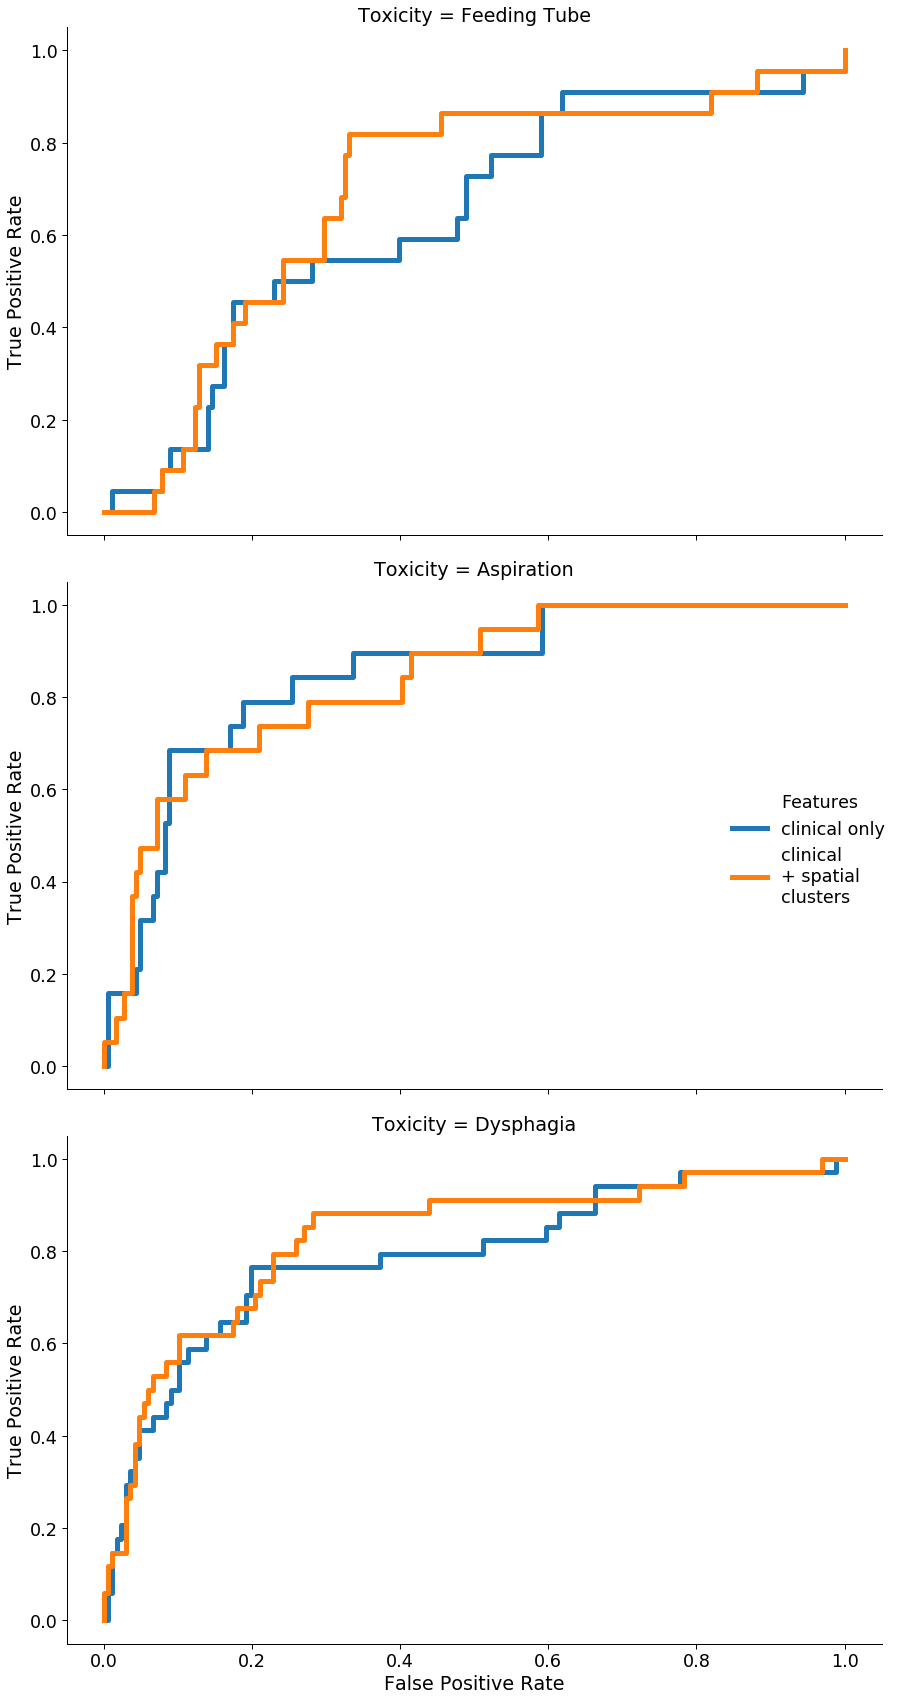

In [101]:

    #commented part makes them all different plots
#     ax = sns.relplot(x='False Positive Rate', y = 'True Positive Rate', 
#                     hue ='Toxicity',
#                     style = 'Features',
#                     data = curves, 
#                     kind='line',
#                     height = fig_height,
#                     aspect = aspect,
#                     estimator = None)
layout_figure(linewidth = 5)
plt.suptitle('ROC Curves')
ax = sns.relplot(x='False Positive Rate', y = 'True Positive Rate', 
                hue ='Features',
                row = 'Toxicity',
                data = curves, 
                kind='line',
                 height = 8,
                 aspect = 1.3,
                 legend = 'brief',
                estimator = None)
plt.tight_layout()

In [19]:
#maybe no use this?
# features_to_drop = []
# temp_scores = []
# spatial = spatial_features.drop(['cluster_labels'], axis = 1)
# best_clusterer = BestClusterer(min_clusters = 2, max_clusters = 5)
# for feature in spatial.columns[::-1]:
#     x = spatial.drop(features_to_drop, axis = 1).values
#     clusters = best_clusterer.fit_predict(x,db.toxicity)
#     temp_scores.append(fisher_exact_test(clusters, db.toxicity))
#     features_to_drop.append(feature)
# plt.plot(np.arange(len(temp_scores)), np.log(1/np.array(temp_scores)[::-1]))

In [25]:
test_range = np.arange(1, 150)
n_subsamples = 500

def get_valid_id_subset(n_to_remove, outcome = 'toxicity', min_value = 2):
    data = db.to_dataframe([outcome])
    dsize = data.shape[0] - n_to_remove
    ids_to_keep = np.random.choice(data.index.values, dsize, replace = False)
    while data.loc[ids_to_keep].sum().values < min_value:
        ids_to_keep = np.random.choice(data.index.values, dsize, replace = False)
    return ids_to_keep

def auc_subset_scores(clusterer, n_subsamples = n_subsamples, test_range = test_range):
    auc_subset_scores = np.zeros((n_subsamples, len(test_range)))
    for pos, n_to_remove in enumerate(test_range):
        subsample_count = np.min([n_subsamples, n_to_remove*db.get_num_patients()])
        for n in range(n_subsamples):
            ids_to_keep = get_valid_id_subset( n_to_remove)
#             ids_to_keep = np.random.choice(db.ids, (db.get_num_patients() - n_to_remove,), replace = False) 
            _, _, auc_score = get_subset_roc(ids_to_keep, clusterer = clusterer)
            auc_subset_scores[n, pos] = auc_score
        print(auc_subset_scores[:,pos].mean())
    sensitivity = pd.DataFrame(auc_subset_scores, columns = test_range)
    return sensitivity

In [22]:
def get_analysis(filename, clusterer):
    try:
        sensitivity = pd.read_csv(filename)
    except:
        print('error reading ' + filename)
        sensitivity = auc_subset_scores(clusterer)
        try:
            sensitivity.to_csv(filename, index = False)
            print('saved to ' + filename)
        except:
            print('could not save file for some reason')
    print(sensitivity.describe())
    return sensitivity
cluster_file = 'data/sensitivity_analysis_clusters.csv'
sensitivity_clusters = get_analysis(cluster_file, default_clusterer())

                1           2           3           4           5           6  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean     0.821615    0.817933    0.817729    0.816667    0.815109    0.813586   
std      0.011677    0.015714    0.017043    0.018857    0.019631    0.021555   
min      0.781462    0.771521    0.762879    0.761814    0.760007    0.733751   
25%      0.820372    0.812157    0.808553    0.805190    0.801608    0.798939   
50%      0.822282    0.821198    0.820523    0.818799    0.817006    0.816803   
75%      0.824458    0.824426    0.827097    0.828794    0.826949    0.826498   
max      0.852866    0.867401    0.860310    0.862428    0.861205    0.867670   

                7           8           9          10  ...         140  \
count  500.000000  500.000000  500.000000  500.000000  ...  500.000000   
mean     0.812709    0.810453    0.808769    0.807516  ...    0.713823   
std      0.022319    0.022688    0.021731    0.0

In [23]:
nocluster_file = 'data/sensitivity_analysis_noclusters.csv'
sensitivity_no_clusters = get_analysis(nocluster_file, None)

                1           2           3           4           5           6  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean     0.785314    0.784618    0.784817    0.784021    0.783816    0.783929   
std      0.004710    0.006388    0.008352    0.008817    0.010102    0.011842   
min      0.775465    0.764495    0.763636    0.761242    0.761998    0.754799   
25%      0.784135    0.782640    0.781306    0.779513    0.777984    0.776612   
50%      0.784848    0.784075    0.783733    0.783004    0.782974    0.782569   
75%      0.785918    0.786227    0.786945    0.787328    0.788107    0.789015   
max      0.818364    0.826619    0.840341    0.823265    0.832822    0.844647   

                7           8           9          10  ...         140  \
count  500.000000  500.000000  500.000000  500.000000  ...  500.000000   
mean     0.782968    0.783367    0.783646    0.782565  ...    0.698092   
std      0.012030    0.013858    0.015747    0.0

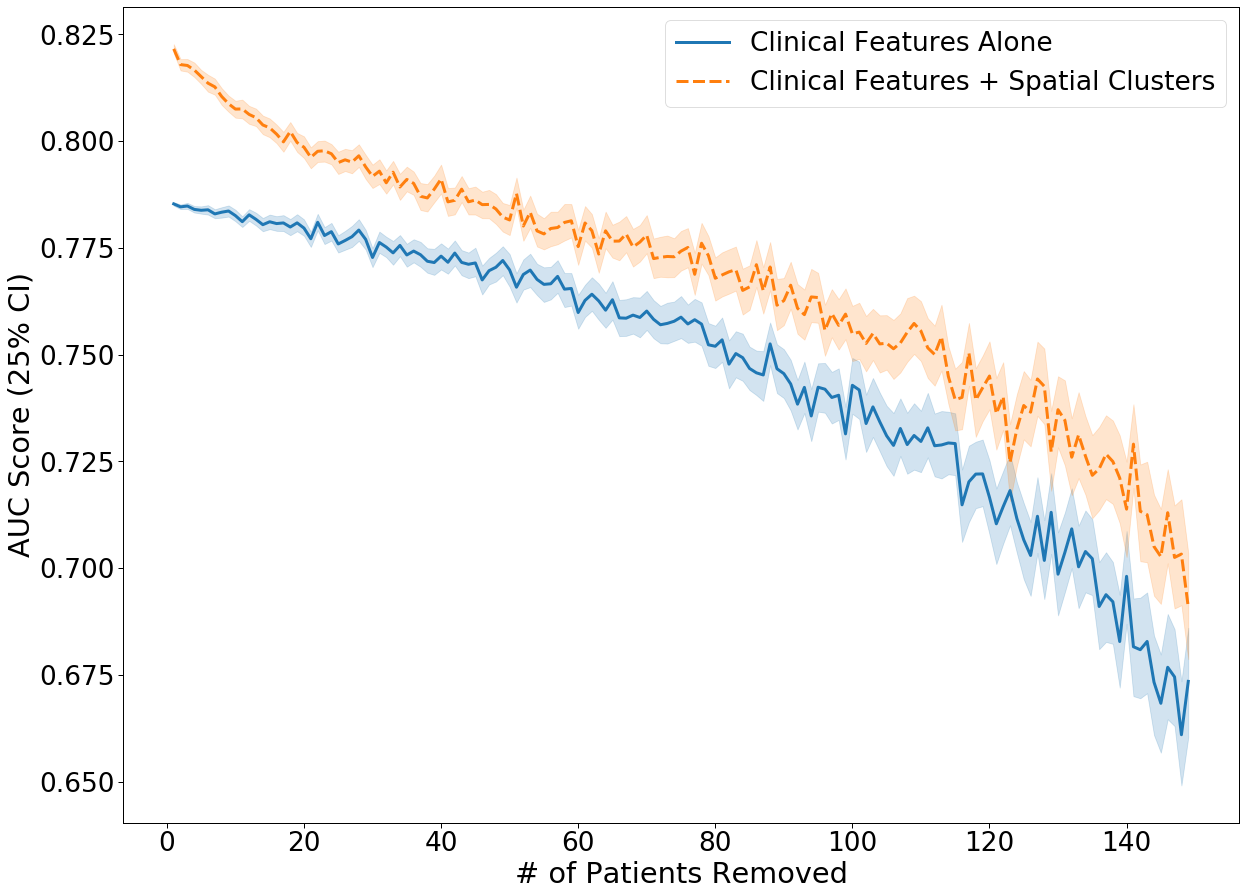

In [104]:
def format_data(report,  max_x = None, min_x = 0):
    report_cols = ['number_removed', 'auc']
    n_steps = np.min([report.shape[1], max_x]) - min_x
    report_data = np.zeros((report.shape[0]*n_steps, 2))
    pos = 0
    for x, r in enumerate(report.T.itertuples()):
        if x < min_x:
            continue
        if max_x is not None and x >= max_x:
            break
        n_patients = r[0]
        for t in r[1:]:
            report_data[pos,:] = [n_patients, t]
            pos += 1
    data = pd.DataFrame(report_data, columns = report_cols)
    return data

def plot_report(report_list, names, max_x = None):
    reports = [format_data(report, max_x) for report in report_list]
    final_report = []
    for report, name in zip(reports, names):
        report['group'] = np.full((report.shape[0],), name)
        final_report.append(report)
    data = pd.concat(final_report, ignore_index = True)
    layout_figure(linewidth = 3, width = 20, height = 15, fontsize = 3)
    fig = sns.lineplot(x='number_removed',y='auc', hue='group',style = 'group', data=data)
    plt.legend(labels = ['Clinical Features Alone', 'Clinical Features + Spatial Clusters'])
    plt.xlabel('# of Patients Removed')
    plt.ylabel('AUC Score (25% CI)')
    
plot_report([sensitivity_no_clusters, sensitivity_clusters], ['no_clusters', 'clusters'], len(test_range))

In [133]:
from sklearn.utils import resample

def get_feature_auc(feature_df = None, outcome_name = 'toxicity', patient_ids = db.ids,
                           classifier = None, cluster = False):
    #pass it an outcome name (feeding_tubes, aspiration, toxicity)
    #and a list of patient ids to use (like for resampling)
    #and a clusterer function and returns the auc curve score from clusters on the spatial
    #feature clusters + clinical features
    if classifier is None:
        classifier = LogisticRegression(solver='lbfgs', max_iter=8000)
    clinical = clinical_features.loc[patient_ids]
    outcomes = db.to_dataframe([outcome_name])
    outcomes = outcomes.loc[patient_ids]
    if feature_df is not None:
        features = feature_df.loc[patient_ids]
        if cluster:
            fvalues = features.values
            if fvalues.ndim < 2:
                fvalues = fvalues.reshape(-1,1)
            clusters = default_clusterer().fit_predict(fvalues)
            clusters = pd.get_dummies(clusters)
            clusters.index = features.index
            features = clusters
        elif isinstance(features, pd.Series):
            features = pd.DataFrame(features)
        clinical = clinical.sort_index()
        features = features.sort_index()
        outcomes = outcomes.sort_index()
        for f in features.columns:
            clinical[f] = features[f].values
    probs = loo_cross_val_proba(classifier, clinical, outcomes,
                               transformer = QuantileTransformer(n_quantiles = len(patient_ids) - 1)
                               )

    auc_score = roc_auc_score(outcomes.values, probs)
    return auc_score

def get_extra_features(dose_organs = ['Mandible', 'Rt_Ant_Digastric_M', 'Lt_Ant_Digastric_M'], 
                       volume_organs = ['Rt_Sternocleidomastoid_M','Lt_Sternocleidomastoid_M', 'Rt_Masseter_M', 'Lt_Masseter_M'], 
                       idx_name = 'Dummy.ID'):
    features = db.to_dataframe(['doses'], organ_list = dose_organs, merge_mirrored_organs = True)
    features = db.to_dataframe(['volumes'], 
                               organ_list = volume_organs, 
                               merge_mirrored_organs = True, 
                               to_merge = features)
    if idx_name is not None:
        features.index = features.index.rename(idx_name)
    return features

def get_features_to_isolate():
    features = get_extra_features()
    features = Metrics.normalize(features)
    features = features.merge(spatial_features.drop('cluster_labels',axis=1), on = ['Dummy.ID'])
    return features

def boostrapped_auc_increase(n_samples = 1):
    features = get_features_to_isolate()
    feature_scores =[]
    for n in range(n_samples):
        print(100*n/n_samples, '% done')
        if n_samples > 1:
            ids = resample(db.ids, stratify = db.toxicity)
        else:
            ids = np.copy(db.ids)
            np.random.shuffle(ids) #I added this for debugging and will keep it in.  Makes sure we know it works with n=1 even if order is changed
        baseline = get_feature_auc(patient_ids = ids)
        print(baseline)
        for use_clusters in (True, False):
            goodest_auc = get_feature_auc(spatial_features.drop('cluster_labels',axis=1), patient_ids = ids, cluster = use_clusters)
            feature_scores.append(['Spatial Features', goodest_auc - baseline, str(use_clusters)])
            for fname in features.columns:
                score = get_feature_auc(features[fname], patient_ids = ids, cluster = use_clusters)
                feature_scores.append([fname, score - baseline , str(use_clusters)])
        print(goodest_auc)
    return pd.DataFrame(feature_scores, columns= ['Feature','AUC','Clustered'])



In [160]:
def get_split_auc(train_ids, test_ids, feature_df = None, outcome_name = 'toxicity', classifier = None, cluster = False):
    #pass it an outcome name (feeding_tubes, aspiration, toxicity)
    #and a list of patient ids to use (like for resampling)
    #and a clusterer function and returns the auc curve score from clusters on the spatial
    #feature clusters + clinical features
    if classifier is None:
        classifier = LogisticRegression(solver='lbfgs', max_iter=8000)
    clinical = clinical_features.copy()
    outcomes = db.to_dataframe([outcome_name])
    outcomes = outcomes.copy()
    if feature_df is not None:
        features = feature_df.copy()
        if cluster:
            fvalues = features.values
            if fvalues.ndim < 2:
                fvalues = fvalues.reshape(-1,1)
            clusters = default_clusterer().fit_predict(fvalues)
            clusters = pd.get_dummies(clusters)
            clusters.index = features.index
            features = clusters
        elif isinstance(features, pd.Series):
            features = pd.DataFrame(features)
        for f in features.columns:
            clinical[f] = features[f].values
    xtrain =clinical.loc[train_ids].values
    xtest = clinical.loc[test_ids].values
    ytrain = outcomes.loc[train_ids].values
    ytest = outcomes.loc[test_ids].values
    classifier.fit(xtrain, ytrain.ravel())
    ypred = classifier.predict_proba(xtest)[:,1]

    auc_score = roc_auc_score(ytest, ypred)
    return auc_score

def random_sample_auc_increase(n_splits = 100, split_size = .25, outcome = 'toxicity'):
    features = get_features_to_isolate()
    tox = db.to_dataframe([outcome])
    spatial = spatial_features.drop('cluster_labels',axis=1)
    feature_scores =[]
    for n in range(n_splits):
        print(100*n/n_splits, '% done')
        train_ids, test_ids = get_id_split(features, tox, split_size)
        baseline = get_split_auc(train_ids, test_ids)
        for use_clusters in (True, False):
            goodest_auc = get_split_auc(train_ids, test_ids,
                                        spatial, 
                                        cluster = use_clusters)
            print(goodest_auc - baseline)
            feature_scores.append(['Spatial Features', goodest_auc - baseline, str(use_clusters)])
            for fname in features.columns:
                score = get_split_auc(train_ids, test_ids,
                                      features[fname], 
                                      cluster = use_clusters)
                feature_scores.append([fname, score - baseline , str(use_clusters)])
    return pd.DataFrame(feature_scores, columns= ['Feature','AUC','Clustered'])

        
def get_id_split(x_df, y_df, split_size):
    split_loc = int(x_df.shape[0]*split_size)+1
    while True:
        ids = np.copy(db.ids)
        np.random.shuffle(ids)
        test_ids = ids[:split_loc]
        train_ids = ids[split_loc:]

        ytrain = y_df.loc[train_ids].values
        ytest = x_df.loc[test_ids].values
        if ytrain.sum() > 2 and ytest.sum() > 2:
            break
    return train_ids, test_ids
        

In [161]:
nsamples = 1000
fdata = random_sample_auc_increase(nsamples)
try:
    fdata.to_csv('data/feature_importances_test_n=' + str(nsamples) + '.csv')
except:
    print('error saving file')

0.0 % done
0.09011627906976738
0.0029069767441860517
0.1 % done
0.015909090909090984
-0.07272727272727264
0.2 % done
0.034391534391534306
0.04761904761904767
0.3 % done
0.10731707317073158
0.02195121951219514
0.4 % done
0.029069767441860517
-0.11627906976744184
0.5 % done
0.03174603174603163
0.005291005291005124
0.6 % done
0.040909090909090895
0.022727272727272818
0.7 % done
0.042735042735042694
0.029914529914529808
0.8 % done
0.00909090909090915
0.018181818181818188
0.9 % done
0.014957264957264904
0.012820512820512775
1.0 % done
0.0714285714285714
0.005291005291005346
1.1 % done
-0.008720930232558044
-0.03197674418604646
1.2 % done
0.06104651162790686
0.06104651162790686
1.3 % done
0.039024390243902585
0.004878048780487809
1.4 % done
-0.023255813953488413
-0.06395348837209303
1.5 % done
0.10317460317460325
0.026455026455026398
1.6 % done
0.031746031746031744
-0.050264550264550234
1.7 % done
0.07073170731707334
0.017073170731707443
1.8 % done
0.03238866396761131
0.036437246963562764
1.

0.0024390243902437936
15.7 % done
-0.005813953488372103
-0.10174418604651159
15.8 % done
0.06590909090909103
0.0386363636363638
15.9 % done
0.07142857142857151
0.05555555555555569
16.0 % done
0.044973544973545
0.013227513227513255
16.1 % done
0.02034883720930225
0.026162790697674354
16.2 % done
0.03658536585365868
0.01463414634146365
16.3 % done
0.061046511627907085
0.04069767441860472
16.4 % done
0.03658536585365846
0.0024390243902437936
16.5 % done
0.0029069767441860517
-0.023255813953488302
16.6 % done
0.004048582995951455
-0.004048582995951455
16.7 % done
0.04220779220779214
0.022727272727272707
16.8 % done
-0.02659574468085102
-0.005319148936170248
16.9 % done
-0.012195121951219523
-0.04390243902439017
17.0 % done
0.038461538461538436
0.019230769230769162
17.1 % done
0.058441558441558406
0.07467532467532467
17.2 % done
0.005813953488372103
-0.046511627906976716
17.3 % done
0.016233766233766378
0.025974025974026094
17.4 % done
0.027272727272727337
0.02954545454545443
17.5 % done
-0

0.06477732793522262
31.2 % done
0.04826254826254839
0.05405405405405406
31.3 % done
-0.021164021164021163
-0.05291005291005291
31.4 % done
-0.011627906976744207
-0.0174418604651162
31.5 % done
0.03863636363636369
-0.02499999999999991
31.6 % done
0.10256410256410253
0.06623931623931623
31.7 % done
-0.012195121951219523
-0.012195121951219634
31.8 % done
-0.011627906976744096
0.008720930232558155
31.9 % done
0.0793650793650793
-0.00793650793650802
32.0 % done
0.042592592592592515
-0.0037037037037037646
32.1 % done
0.062962962962963
0.011111111111111183
32.2 % done
-0.04048582995951433
-0.04858299595141713
32.3 % done
0.017391304347826098
-0.11739130434782613
32.4 % done
0.07777777777777772
0.04444444444444451
32.5 % done
0.039682539682539764
0.05555555555555558
32.6 % done
0.009756097560975507
-0.019512195121951237
32.7 % done
0.06585365853658531
0.0024390243902439046
32.8 % done
0.1428571428571428
-0.10064935064935066
32.9 % done
0.06590909090909092
0.02954545454545454
33.0 % done
0.0365

0.10487804878048768
46.8 % done
0.023809523809523836
-0.013227513227513144
46.9 % done
0.12962962962962976
0.10370370370370374
47.0 % done
0.029268292682926855
-0.024390243902439046
47.1 % done
0.1164021164021164
0.07936507936507942
47.2 % done
0.05982905982905973
-0.012820512820512775
47.3 % done
0.012195121951219412
-0.09512195121951217
47.4 % done
-0.039024390243902474
-0.017073170731707443
47.5 % done
0.03779069767441856
-0.05813953488372092
47.6 % done
0.10052910052910069
0.029100529100529182
47.7 % done
0.10064935064935066
0.012987012987012991
47.8 % done
0.09615384615384615
-0.019230769230769162
47.9 % done
0.06818181818181823
0.04772727272727273
48.0 % done
0.0032467532467532756
-0.0032467532467531646
48.1 % done
0.044534412955465674
-0.020242914979756943
48.2 % done
0.12234042553191493
0.05319148936170204
48.3 % done
0.05227272727272714
-1.1102230246251565e-16
48.4 % done
0.05813953488372081
0.05523255813953476
48.5 % done
0.022727272727272818
0.011363636363636465
48.6 % done


0.03779069767441856
62.3 % done
0.15609756097560978
0.1048780487804879
62.4 % done
0.012820512820512775
-0.023504273504273532
62.5 % done
0.025925925925925908
-0.11111111111111105
62.6 % done
0.05982905982905984
0.010683760683760646
62.7 % done
0.043604651162790664
-0.026162790697674354
62.8 % done
-0.039024390243902474
-0.07073170731707323
62.9 % done
-0.06395348837209303
-1.1102230246251565e-16
63.0 % done
0.014534883720930147
-0.01744186046511631
63.1 % done
0.06104651162790686
0.07558139534883712
63.2 % done
0.024390243902438935
-0.024390243902439046
63.3 % done
0.04999999999999982
0.040909090909090784
63.4 % done
0.08048780487804874
0.02682926829268295
63.5 % done
1.1102230246251565e-16
-0.05681818181818177
63.6 % done
0.12169312169312174
0.06878306878306872
63.7 % done
0.09716599190283415
0.03441295546558709
63.8 % done
0.03968253968253965
0.05291005291005291
63.9 % done
0.044973544973545
0.013227513227513366
64.0 % done
0.06563706563706562
0.021235521235521193
64.1 % done
0.0610

0.0064102564102563875
77.8 % done
0.024390243902439046
-0.019512195121951237
77.9 % done
0.05232558139534882
-0.09883720930232565
78.0 % done
0.06613756613756616
0.04497354497354489
78.1 % done
0.03197674418604646
0.0174418604651162
78.2 % done
0.038961038961038974
0.019480519480519543
78.3 % done
0.10052910052910058
-0.002645502645502673
78.4 % done
0.03968253968253954
0.013227513227513144
78.5 % done
0.02316602316602312
0.01158301158301156
78.6 % done
0.04069767441860461
-0.011627906976744207
78.7 % done
0.045454545454545414
0.06818181818181823
78.8 % done
0.05232558139534882
-0.023255813953488413
78.9 % done
0.08547008547008539
0.06623931623931612
79.0 % done
0.0714285714285714
0.05820105820105814
79.1 % done
0.029220779220779147
0.00649350649350644
79.2 % done
0.04941860465116277
-0.0029069767441861627
79.3 % done
0.10174418604651148
0.05813953488372092
79.4 % done
0.05185185185185193
0.0444444444444444
79.5 % done
0.01619433198380571
0.020242914979757054
79.6 % done
0.109311740890

0.051948051948051965
93.3 % done
0.12169312169312174
0.05291005291005291
93.4 % done
0.017073170731707332
-0.10487804878048779
93.5 % done
0.00909090909090915
-0.09090909090909083
93.6 % done
-0.01587301587301604
0.026455026455026287
93.7 % done
0.10000000000000009
-0.007317073170731714
93.8 % done
0.023809523809523836
0.002645502645502562
93.9 % done
0.08536585365853666
0.004878048780487698
94.0 % done
0.09302325581395343
0.07848837209302317
94.1 % done
0.043902439024390394
-0.01707317073170722
94.2 % done
0.026455026455026398
0.005291005291005346
94.3 % done
0.05984555984555984
0.06563706563706562
94.4 % done
0.12012987012987031
0.01948051948051943
94.5 % done
-0.04390243902439017
-0.08780487804878045
94.6 % done
0.04870129870129869
0.045454545454545414
94.7 % done
0.04487179487179482
0.017094017094017033
94.8 % done
0.025000000000000022
-0.018181818181818188
94.9 % done
0.013227513227513255
-0.007936507936507908
95.0 % done
0.040598290598290565
0.03205128205128205
95.1 % done
0.0232

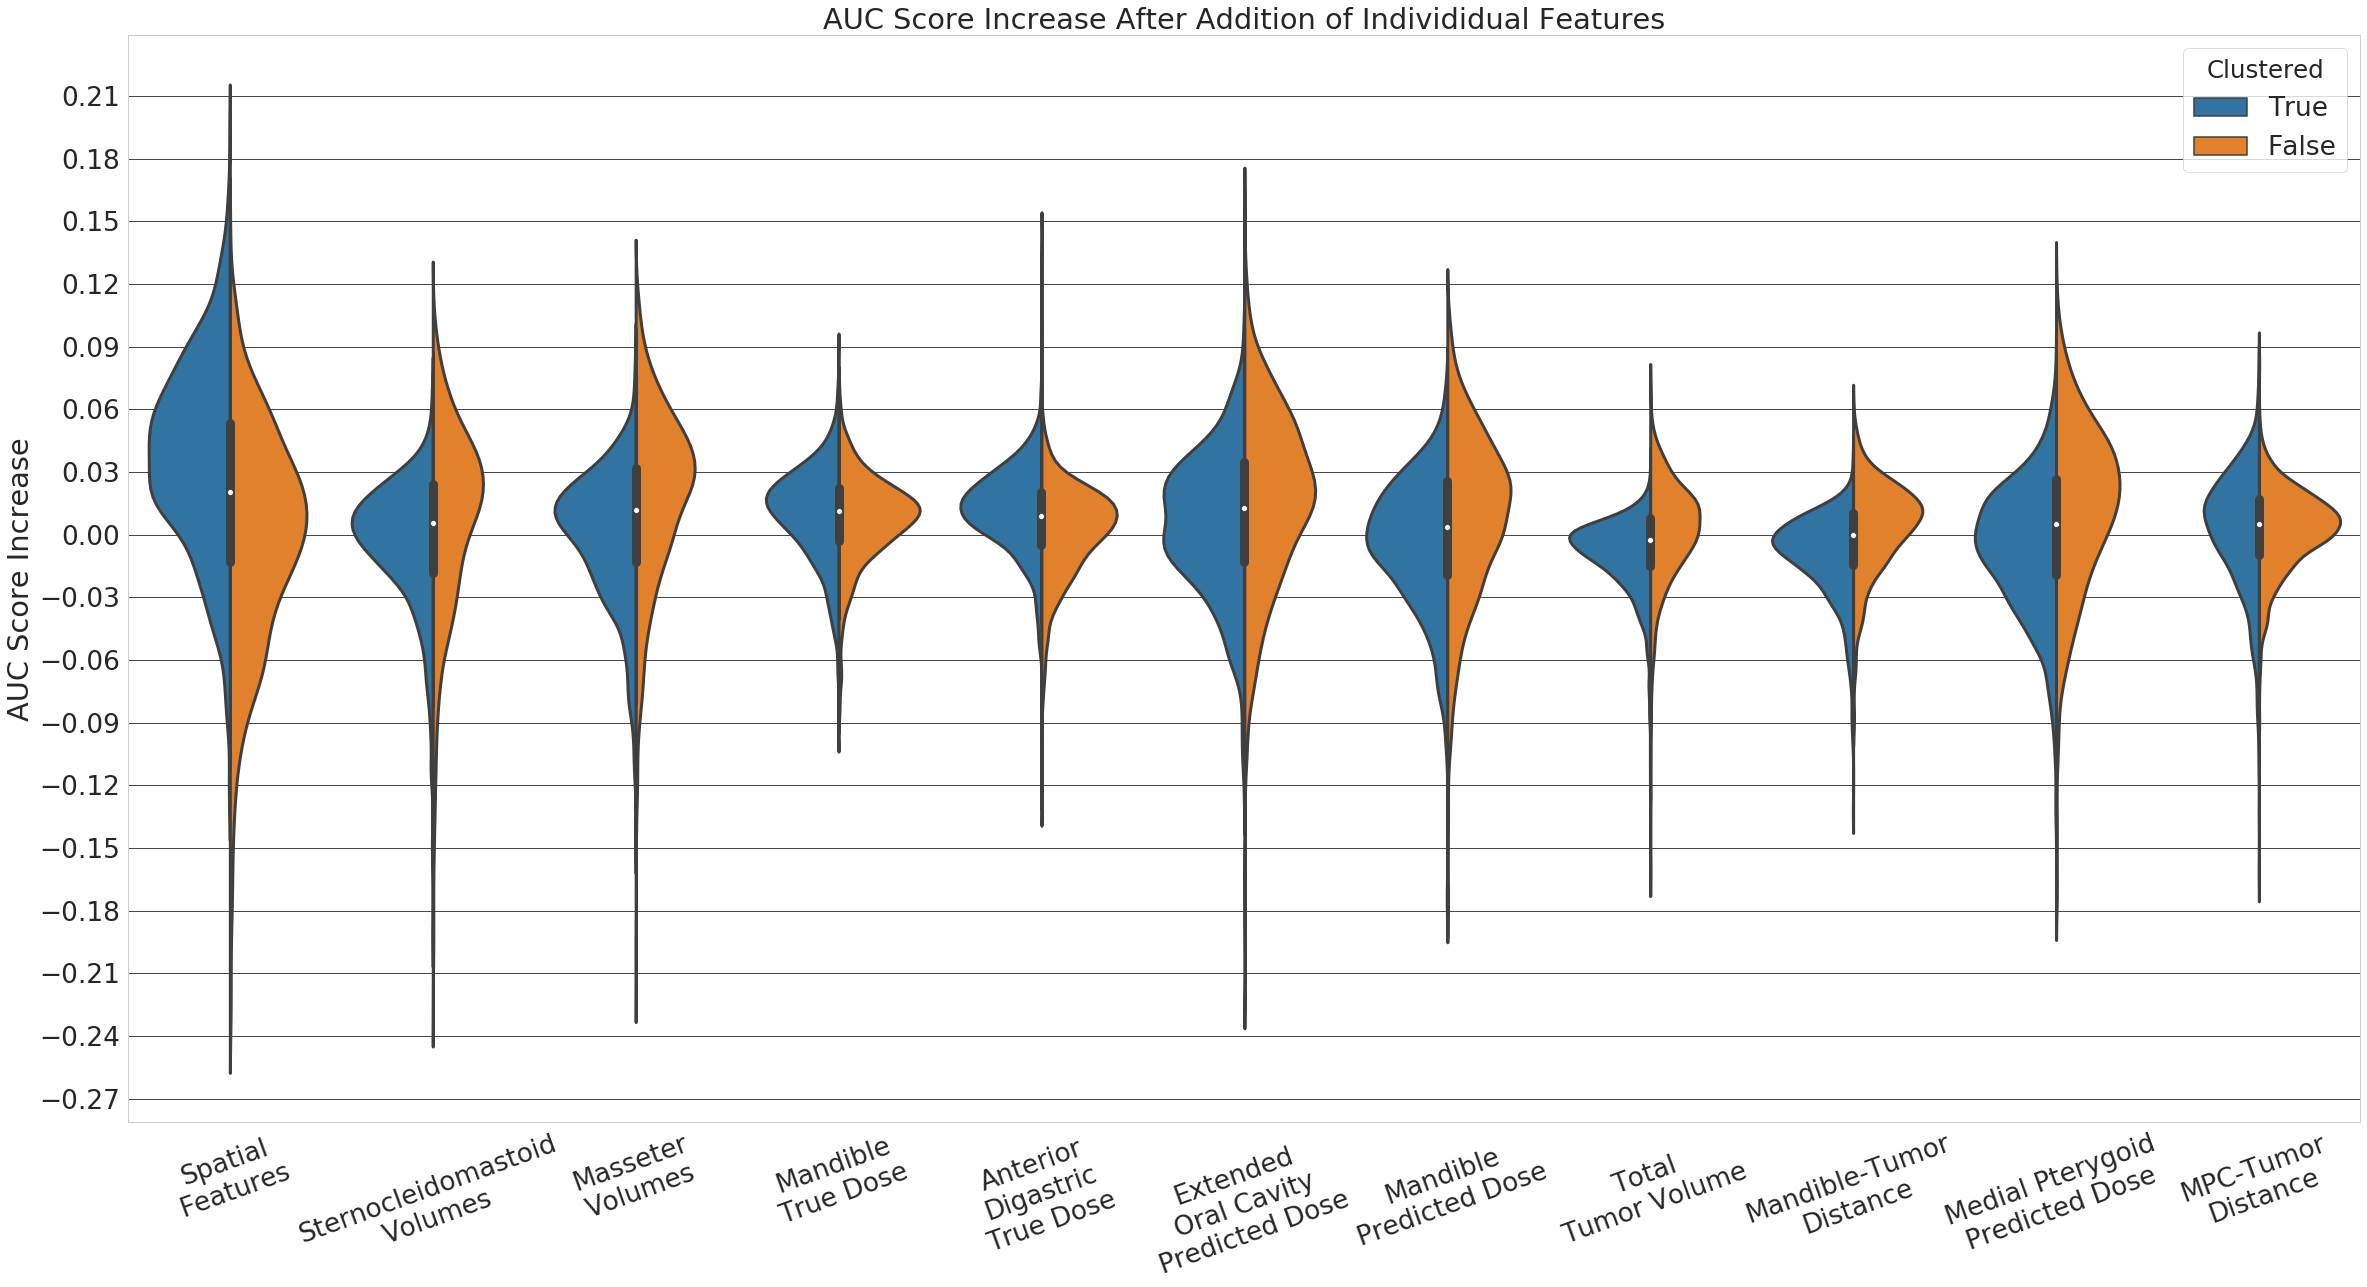

In [213]:
layout_figure(linewidth = 3, width = 40, height = 20, fontsize = 3)
from matplotlib.ticker import MultipleLocator
with sns.axes_style(rc = {'axes.grid':True,
                          'grid.color': '0.1',
                         }):
    label_names = ['Spatial\nFeatures', 'Sternocleidomastoid\nVolumes','Masseter\nVolumes', 
                'Mandible\nTrue Dose', 'Anterior\nDigastric\nTrue Dose', 
                'Extended\nOral Cavity\nPredicted Dose',
               'Mandible\nPredicted Dose', 'Total\nTumor Volume',
               'Mandible-Tumor\nDistance', 'Medial Pterygoid\nPredicted Dose',
               'MPC-Tumor\nDistance']
    if nsamples == 1:
        ax = sns.barplot(y = 'Feature',x = 'AUC', data = fdata, orient='h', hue = "Clustered")
        plt.xlabel('AUC Score Increase')
        plt.yticks(np.arange(len(label_names)), label_names)
        plt.xlabel('')
        ax.xaxis.set_major_locator(MultipleLocator(.03))
    else:
        ax = sns.violinplot(x = 'Feature', y = 'AUC', 
                            data = fdata, orient='v', 
                            hue = "Clustered", 
                            showfliers=False,
                           split=True)
        plt.ylabel('AUC Score Increase')
        plt.xticks(np.arange(len(label_names)), label_names, rotation = 20)
        plt.xlabel('')
        ax.yaxis.set_major_locator(MultipleLocator(.03))
    plt.title('AUC Score Increase After Addition of Individidual Features')

In [125]:
fdata

,Feature,AUC,Clustered
0,Spatial Features,-0.548193,True
1,Sternocleidomastoid_M_volumes_combined,-0.382176,True
2,Masseter_M_volumes_combined,-0.521793,True
3,Mandible_doses,-0.556697,True
4,Ant_Digastric_M_doses_combined,-0.592310,True
5,Extended_Oral_Cavity_tsimdoses,-0.580262,True
6,Mandible_tsimdoses,-0.525691,True
7,t_volumes_0,-0.562190,True
8,Mandible_tumor_distances,-0.594614,True
9,Medial_Pterygoid_M_tsimdoses_combined,-0.561127,True
